### Preparing Data for Prophet

First, we need to import the `Prophet` library. Prophet has a strict requirement
for its input DataFrame: it must contain a column named `ds` for the datestamps
and a column named `y` for the values we want to forecast. We will load our
weekly aggregated data, reset the index to turn the date index into a column,
and then rename the columns to match Prophet's requirements.

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the pre-processed weekly data.
df_daily = pd.read_csv('warehouse_daily_volume.csv')
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily.set_index('date', inplace=True)
df_weekly = df_daily['volume'].resample('W').sum().to_frame()

# Prepare the dataframe for Prophet
df_prophet = df_weekly.reset_index()
df_prophet.rename(columns={'date': 'ds', 'volume': 'y'}, inplace=True)

print("Data prepared for Prophet:")
print(df_prophet.head())

/opt/anaconda3/envs/warehouse_forecast/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data prepared for Prophet:
          ds    y
0 2022-01-02   65
1 2022-01-09  384
2 2022-01-16  420
3 2022-01-23  341
4 2022-01-30  436


### Training the Model

Now we will instantiate and train our Prophet model. We create an instance
of the `Prophet` class. We can pass in parameters to configure its behavior;
here, we explicitly tell it to look for `yearly_seasonality`. Then, we simply
call the `.fit()` method on our prepared DataFrame. Prophet will automatically
"learn" the trend and seasonality from the `ds` and `y` columns.

In [2]:
# Instantiate the Prophet model with yearly seasonality
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

# Fit the model to our data
model.fit(df_prophet)

print("Prophet model has been trained.")

22:25:08 - cmdstanpy - INFO - Chain [1] start processing
22:25:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet model has been trained.


### Creating a Future Dataframe for Forecasting

To make a forecast, we need to provide the model with a DataFrame of future dates.
Prophet has a convenient helper function called `make_future_dataframe()` for this.
We specify the number of `periods` we want to forecast and the `freq` (frequency)
of those periods. For our goal, we need to forecast 4 weeks into the future,
so we set `periods=4` and `freq='W'`.

In [3]:
# Create a dataframe with future dates for the next 4 weeks
future = model.make_future_dataframe(periods=4, freq='W')

print("Future dataframe for prediction:")
print(future.tail())

Future dataframe for prediction:
            ds
157 2025-01-05
158 2025-01-12
159 2025-01-19
160 2025-01-26
161 2025-02-02


### Generating the Forecast
#
With our trained model and the future dates, we can now generate the forecast
using the `.predict()` method. The output is a new DataFrame containing the
forecast (`yhat`), the uncertainty intervals (`yhat_lower` and `yhat_upper`),
and the individual components of the forecast. We will inspect the last few rows
to see our 4-week prediction.

In [6]:
# Use the model to make a forecast on the future dataframe
forecast = model.predict(future)

# Display the key forecast results for the future 4 weeks
print("Forecast results:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(4))
# yhat: The forecasted value.
# yhat_lower: The lower bound of the uncertainty interval.
# yhat_upper: The upper bound of the uncertainty interval.

Forecast results:
            ds         yhat   yhat_lower   yhat_upper
158 2025-01-12  1034.932196   956.000587  1130.421691
159 2025-01-19  1104.692467  1014.696503  1197.261024
160 2025-01-26  1161.648571  1075.540755  1253.552304
161 2025-02-02  1188.897755  1101.661045  1273.556438


### Visualizing the Forecast

A visual plot of the forecast is the most effective way to understand the model's
predictions. Prophet has a built-in `.plot()` method that creates a clear
visualization showing the historical data, the forecasted values, and the
uncertainty interval. This plot is essential for communicating the results.

/opt/anaconda3/envs/warehouse_forecast/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/warehouse_forecast/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


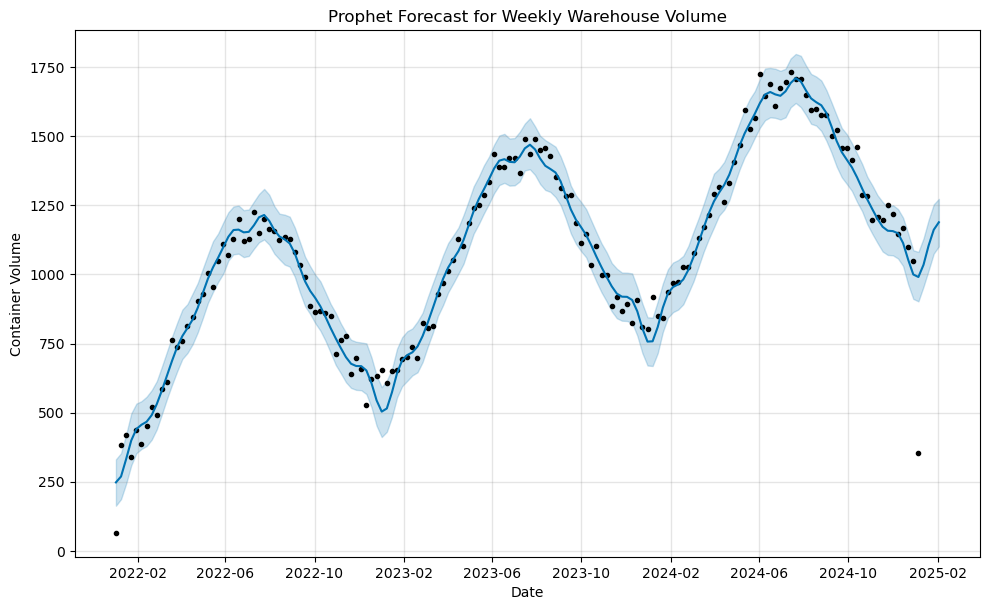

In [7]:
# Plot the forecast using Prophet's built-in plotting function
fig1 = model.plot(forecast)
plt.title('Prophet Forecast for Weekly Warehouse Volume')
plt.xlabel('Date')
plt.ylabel('Container Volume')
plt.show()

### Visualizing Forecast Components

To better understand *how* the model is making its predictions, we can plot its
individual components. The `plot_components` function shows the overall trend and
any seasonal patterns (e.g., yearly) that the model has identified. This provides
valuable insight into the underlying drivers of the warehouse volume.

/opt/anaconda3/envs/warehouse_forecast/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/warehouse_forecast/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/envs/warehouse_forecast/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python d

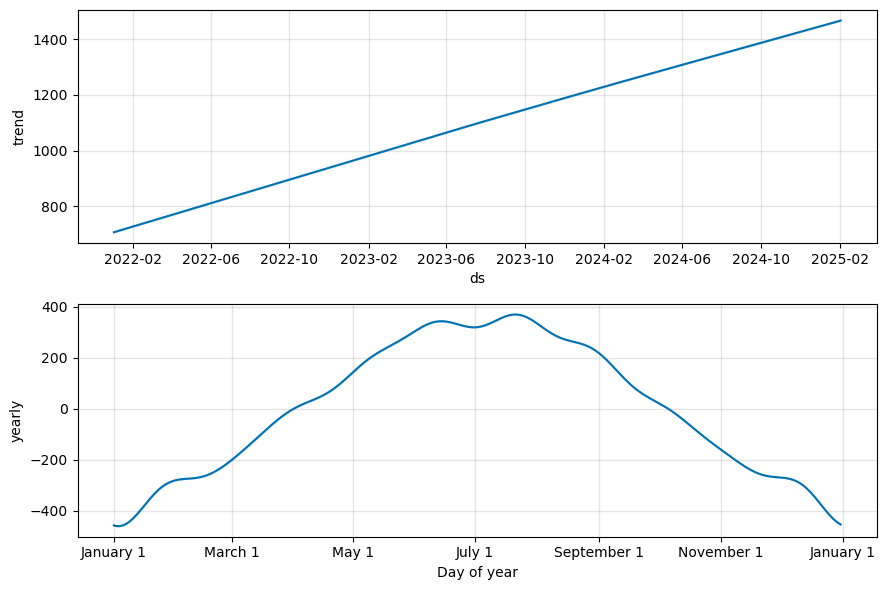

In [8]:
# Plot the trend and seasonal components of the forecast
fig2 = model.plot_components(forecast)
plt.show()

### Creating a Train/Test Split

We will split our data into a training set and a test set. A common approach
is to use the last year (52 weeks) of data as the test set to see how well
the model can predict a full seasonal cycle. The rest of the data will be used
for training. For time-series, this split must be chronological.

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split the data: use the last 52 weeks for testing
train = df_prophet.iloc[:-52]
test = df_prophet.iloc[-52:]

print(f"Training data points: {len(train)}")
print(f"Testing data points: {len(test)}")

Training data points: 106
Testing data points: 52


### Training a New Model on the Training Set

We now repeat the training process, but this time, we only use the `train`
DataFrame. This ensures that the model never sees the test data during training,
simulating a real-world scenario where the future is unknown.

In [10]:
# Instantiate a new model for evaluation
eval_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

# Fit the model ONLY on the training data
eval_model.fit(train)

print("Evaluation model trained on the training set.")

22:30:30 - cmdstanpy - INFO - Chain [1] start processing
22:30:31 - cmdstanpy - INFO - Chain [1] done processing


Evaluation model trained on the training set.


### Forecasting for the Test Period

Next, we create a "future" dataframe that covers the dates of our test set.
We then use our newly trained `eval_model` to predict the values for this period.
This will give us a `yhat` forecast for the same timeframe as our `test` data's
actual `y` values.

In [11]:
# Create a future dataframe that spans the test period
future_eval = eval_model.make_future_dataframe(periods=52, freq='W')

# Generate the forecast
forecast_eval = eval_model.predict(future_eval)

print("Forecast generated for the test period.")

Forecast generated for the test period.


### Visual Evaluation: Comparing Forecast to Actuals

The most intuitive way to evaluate performance is to plot the forecasted values
(`yhat`) directly against the actual values (`y`) from the test set. This visual
check will immediately tell us if the model is capturing the patterns correctly
and how close its predictions are.

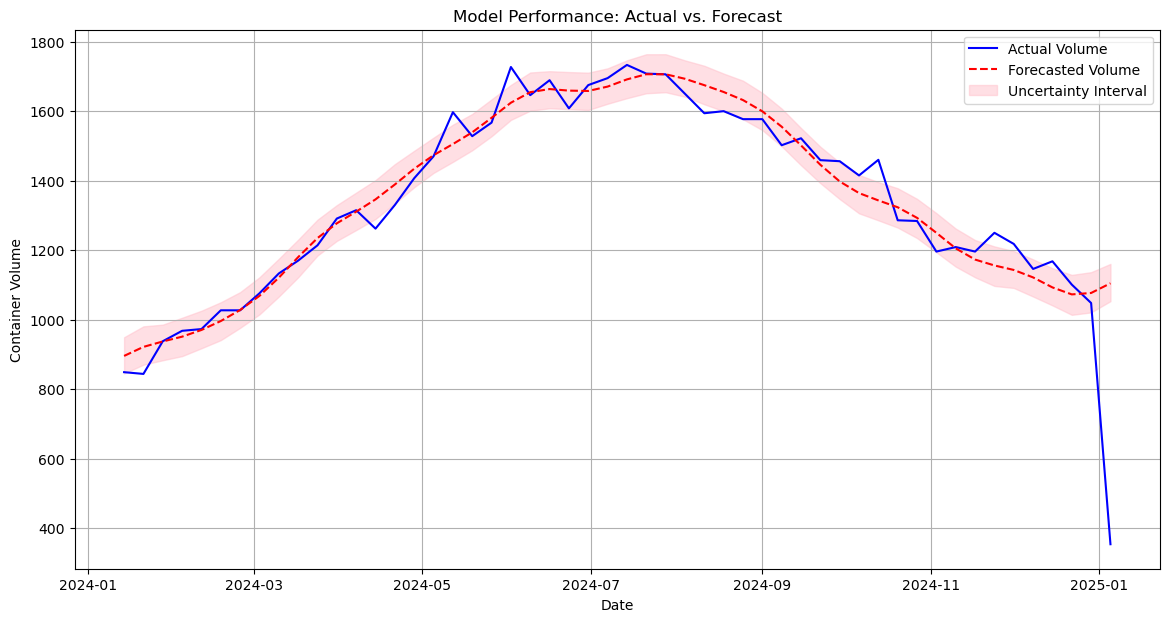

In [12]:
# Merge the forecast with the actual test data for comparison
# We need to make sure the 'ds' columns align
test_forecast = pd.merge(test, forecast_eval[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

# Plot actuals vs. forecast
plt.figure(figsize=(14, 7))
plt.plot(test_forecast['ds'], test_forecast['y'], label='Actual Volume', color='blue')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Forecasted Volume', color='red', linestyle='--')
plt.fill_between(test_forecast['ds'],
                 test_forecast['yhat_lower'],
                 test_forecast['yhat_upper'],
                 color='pink', alpha=0.5, label='Uncertainty Interval')

plt.title('Model Performance: Actual vs. Forecast')
plt.xlabel('Date')
plt.ylabel('Container Volume')
plt.legend()
plt.grid(True)
plt.show()

### Quantitative Evaluation: Error Metrics

Visuals are great, but we also need quantitative metrics to assess accuracy.
We will calculate three common regression metrics:

- MAE (Mean Absolute Error): The average absolute difference between the
  forecast and the actuals. Easy to interpret in original units.
  $MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$

- MSE (Mean Squared Error): The average of the squared errors. Penalizes
  larger errors more heavily.
  $MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$

- RMSE (Root Mean Squared Error): The square root of the MSE. Also in the
  original units and is a very common metric for forecast accuracy.
  $RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$

In [13]:
# Calculate error metrics
mae = mean_absolute_error(test_forecast['y'], test_forecast['yhat'])
mse = mean_squared_error(test_forecast['y'], test_forecast['yhat'])
rmse = np.sqrt(mse)

# Print the results
print("--- Model Evaluation Metrics ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Interpretation
avg_volume = test_forecast['y'].mean()
print(f"\nInterpretation: The model's forecast is, on average, off by ~{mae:.0f} containers per week (MAE).")
print(f"The average weekly volume in the test set was ~{avg_volume:.0f} containers.")

--- Model Evaluation Metrics ---
Mean Absolute Error (MAE): 49.62
Mean Squared Error (MSE): 12996.23
Root Mean Squared Error (RMSE): 114.00

Interpretation: The model's forecast is, on average, off by ~50 containers per week (MAE).
The average weekly volume in the test set was ~1335 containers.
